In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, FalsePositives, FalseNegatives

2024-06-17 18:39:09.472964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 18:39:09.473007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 18:39:09.473848: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 18:39:09.479349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 18:39:10.173305: W tensorflow/compiler/tf2

In [2]:
# Data augmentation parameters
data_gen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=[0.7, 0.8],
    shear_range=0.2,
    fill_mode='nearest'
)

In [3]:
# Load the pre-trained MobileNetV3Small model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


2024-06-17 18:39:19.799637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


4334752/4334752 [==============================] - 0s 0us/step


In [4]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [8]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # Output layer with 3 classes
])

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])


In [13]:

# Data generators
train_generator = data_gen.flow_from_directory('./scaled-mulberry-leaf-dataset/output/train', target_size=(224, 224), batch_size=32)
validation_generator = data_gen.flow_from_directory('./scaled-mulberry-leaf-dataset/output/val', target_size=(224, 224), batch_size=32)


Found 872 images belonging to 3 classes.
Found 108 images belonging to 3 classes.


In [16]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/60


2024-06-17 18:46:35.013718: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-17 18:46:36.180060: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbe54144c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-17 18:46:36.180092: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-06-17 18:46:36.200524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718649996.349724    4892 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - 14s 369ms/step - loss: 2.0886 - accuracy: 0.7179 - precision: 0.7206 - recall: 0.7156 - val_loss: 0.6487 - val_accuracy: 0.8889 - val_precision: 0.8972 - val_recall: 0.8889
Epoch 2/60
28/28 [==============================] - 10s 352ms/step - loss: 0.6196 - accuracy: 0.8865 - precision: 0.8863 - recall: 0.8853 - val_loss: 0.3448 - val_accuracy: 0.9167 - val_precision: 0.9245 - val_recall: 0.9074
Epoch 3/60
28/28 [==============================] - 9s 334ms/step - loss: 0.3496 - accuracy: 0.9300 - precision: 0.9322 - recall: 0.9300 - val_loss: 0.2877 - val_accuracy: 0.9074 - val_precision: 0.9074 - val_recall: 0.9074
Epoch 4/60
28/28 [==============================] - 9s 339ms/step - loss: 0.2506 - accuracy: 0.9381 - precision: 0.9412 - recall: 0.9369 - val_loss: 0.1434 - val_accuracy: 0.9444 - val_precision: 0.9444 - val_recall: 0.9444
Epoch 5/60
28/28 [==============================] - 10s 343ms/step - loss: 0.2218 - accuracy: 0.9530 - precision:

In [23]:
# Evaluate the model on the test dataset
test_generator = ImageDataGenerator().flow_from_directory('./scaled-mulberry-leaf-dataset/output/test', target_size=(224, 224), batch_size=32)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

# Calculate F1 score
true_positives = test_recall * (test_recall + test_precision)
f1_score = 2 * true_positives / (2 * true_positives + test_precision + test_recall)

Found 111 images belonging to 3 classes.
4/4 [==============================] - 0s 119ms/step - loss: 0.2364 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550


In [24]:
model.evaluate(test_generator)

4/4 [==============================] - 0s 96ms/step - loss: 0.2364 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550


[0.23644772171974182, 0.954954981803894, 0.954954981803894, 0.954954981803894]

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, FalsePositives, FalseNegatives
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

Test Loss: 0.23644781112670898
Test Accuracy: 0.954954981803894
Test Precision: 0.954954981803894
Test Recall: 0.954954981803894
Test F1 Score: 0.6563467555675943
4/4 [==============================] - 1s 86ms/step


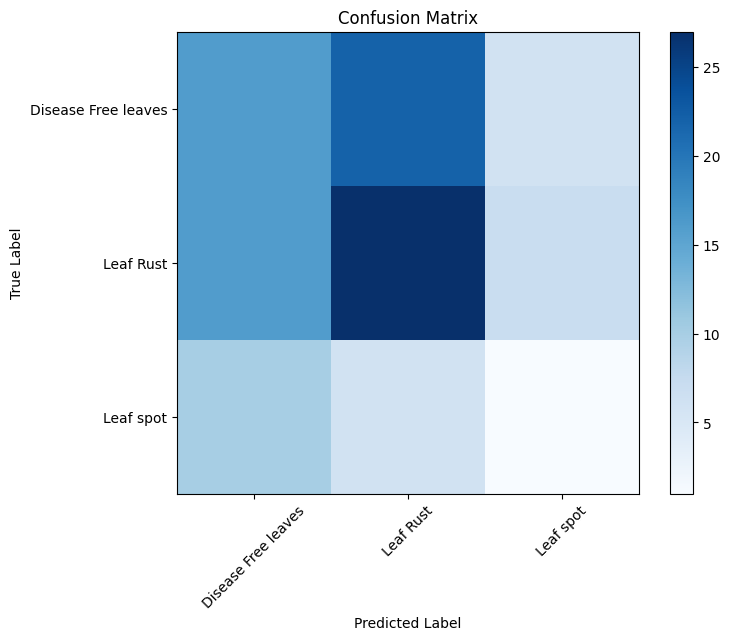

In [26]:
# Calculate F1 score
true_positives = test_recall * (test_recall + test_precision)
f1_score = 2 * true_positives / (2 * true_positives + test_precision + test_recall)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {f1_score}")

# Compute and plot the confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(test_generator.class_indices)), list(test_generator.class_indices.keys()), rotation=45)
plt.yticks(np.arange(len(test_generator.class_indices)), list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Calculate the average and standard deviation
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

std_precision = np.std(precision_scores)
std_recall = np.std(recall_scores)
std_f1 = np.std(f1_scores)

NameError: name 'precision_scores' is not defined